In [1]:
#!/usr/bin/env Rscript
# 功能：从 featureCounts 输出计算 RPKM，并比较核内（N）和核外（C）基因表达差异
source("/home/user/data2/lit/bin/lit_utils.R")
source("/home/user/data3/lit/project/sORFs/sORFs.utils.R")
lib_text()
lib_plot()
setwd("/home/user/data3/lit/project/sORFs/06-RNA-seq")
###### libsize为UNIQUELY MAPPED READS而不是featureCounts assigned reads ######
fc_output_file <- "/home/user/data3/lit/project/sORFs/06-RNA-seq/02-output-20250621/featureCounts/rna-seq-counts.txt"
fread_c(fc_output_file)  -> rna_counts
libsize <- fread_c("./02-output-20250621/expr/sample_name.lib.txt")
colnames(libsize) <- c("Sample","libsize")
libsize

# 重命名列
colnames(rna_counts[,7:ncol(rna_counts)]) %>% sub("/home/user/data3/lit/project/sORFs/06-RNA-seq/02-output-20250621/mapping/","",.) %>% 
  sub(".R1_Aligned.sortedByCoord.out.bam","",.) -> colnames_organized
head(colnames_organized)

Sample,libsize
<chr>,<int>
p21_C_1,38803745
p21_C_2,41777492
p21_C_3,531854766
p21_N_1,46910288
p21_N_2,651425046


[1] "p21_C_1" "p21_C_2" "p21_C_3" "p21_N_1" "p21_N_2"

In [2]:
colnames_organized_1 <- c("C_1","C_2","C_3","N_1","N_2")
# 计算RPKM
get_rpkm <- function(counts,libsize){
  rkm <- counts[,7:ncol(counts)]/counts$Length*1000
  rpkm <- data.frame(t(t(rkm) / libsize) * 10^6 )
  return(rpkm)
}
fread_c(fc_output_file)  -> rna_counts
# 确保libsize样本的顺序和counts中样本的顺序是一致的【已确认】
all(libsize$Sample==colnames_organized)
get_rpkm(rna_counts,libsize$libsize) -> rpkm
colnames(rpkm) <- colnames_organized_1
head(rpkm)

[1] TRUE

,C_1,C_2,C_3,N_1,N_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0000000,0.00000000,0.00000000,0.000000,0.0008847816
2,0.6676349,0.90359218,0.89348368,1.846131,1.5850917525
3,0.3789810,0.00000000,0.00000000,3.134895,3.6571405349
4,0.0000000,0.04688802,0.01473232,0.000000,0.0000000000
5,0.0000000,0.00000000,0.00000000,0.000000,0.0000000000
6,0.0000000,0.00000000,0.00000000,0.000000,0.0000000000


In [3]:
# 核内三个重复以及核外两个重复之间的相关性都很好
cor(rpkm, method = "pearson")

,C_1,C_2,C_3,N_1,N_2
C_1,1.0000000,0.9999970,0.9999978,0.6417088,0.6353970
C_2,0.9999970,1.0000000,0.9999998,0.6416423,0.6353301
C_3,0.9999978,0.9999998,1.0000000,0.6416335,0.6353217
N_1,0.6417088,0.6416423,0.6416335,1.0000000,0.9990553
N_2,0.6353970,0.6353301,0.6353217,0.9990553,1.0000000


In [4]:
## 合并
mutate(rpkm,C=(C_1+C_2+C_3)/3,N=(N_1+N_2)/2) %>% dplyr::select(C,N) -> rpkm_N_C
head(rpkm_N_C)

,C,N
,<dbl>,<dbl>
1,0.00000000,0.0004423908
2,0.82157026,1.7156111605
3,0.12632700,3.3960177273
4,0.02054011,0.0000000000
5,0.00000000,0.0000000000
6,0.00000000,0.0000000000


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message in brewer.pal(n = n_distinct(data[, x]), name = "Set3"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


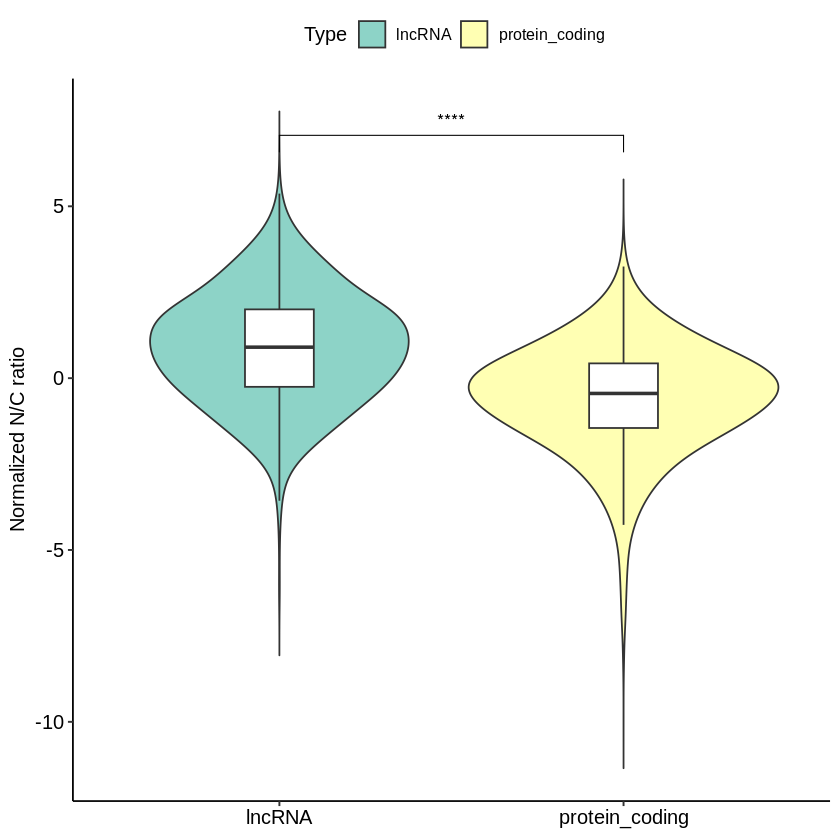

In [5]:
# 比较lncRNA和protein-coding基因的NC ratio
rpkm_N_C$Geneid <- rna_counts$Geneid
## 过滤低表达基因
filter(rpkm_N_C,N+C>=0.2) -> rpkm_N_C_expressed
## 导入转录本基因信息
fread("/home/user/data2/lit/project/ZNF271/data/annotation/Ensembl_106_Gencode_v41_Human_Transcript_stable_ID_version_Gene_stable_ID_version_Gene_name_Transcript_type_gene_type.txt",header = F,data.table = F) -> info
# head(info)
distinct(info,V1,V4) %>% merge(rpkm_N_C_expressed,by.x="V1",by.y="Geneid") -> rpkm_N_C_expressed_add_gt
# table(rpkm_N_C_expressed_add_gt$V4) %>% sort()
## 比较lncRNA和protein-coding基因
filter(rpkm_N_C_expressed_add_gt,V4 %in% c("lncRNA","protein_coding")) -> rpkm_N_C_expressed_lnc_pc
## 计算log2((N+0.1)/(C+0.1))
rpkm_N_C_expressed_lnc_pc %>% mutate(NC_ratio=log2((N+0.1)/(C+0.1))) -> rpkm_N_C_expressed_lnc_pc
# table(rpkm_N_C_expressed_lnc_pc$V4)
## 调整violin plot的参数bw
box_violin_plot_v1 <- function(data,x,y,fill_col,log10=T,bw=0.1){
  # log10 是否启用对数坐标轴，注意如果数据中有零值，那么会作图的时候会自动去掉这些值
  ggplot(data,aes_string(x=x,y=y,fill=fill_col))+
    geom_violin(trim = F,bw=bw)+
    geom_boxplot(outlier.shape = NA,fill="white",width=0.2)+
    scale_fill_manual(values = brewer.pal(n=n_distinct(data[,x]),name="Set3"))+
    theme_3() -> p
  if(log10){
    p+scale_y_log10(labels = label_number())->p
  }
  return(p)
}
box_violin_plot_v1(rpkm_N_C_expressed_lnc_pc,x = "V4",y = "NC_ratio",fill_col ="V4",log10 = F,bw=0.5) ->p
p+labs(y="Normalized N/C ratio",fill="Type",x=NULL) -> p
compare(p,list(c("lncRNA","protein_coding"))) -> p_1
p_1
create_path("./02-output-20250621//expr/plot/")
ggsave(p_1,filename = "./02-output-20250621//expr/plot/lnc_pc_ncRatio.pdf",width = 5,height = 5)

# 导出基因的表达信息
rpkm_N_C %>% mutate(A=(N+C)/2) -> rpkm_N_C_A
fwrite_c(rpkm_N_C_A, "./02-output-20250621//expr/rpkm_N_C_A.txt")

In [6]:
head(rpkm_N_C_expressed_lnc_pc)
table(rpkm_N_C_expressed_lnc_pc$V4)

,V1,V4,C,N,NC_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003.15,protein_coding,1.7932026,0.4443332,-1.79826701
2,ENSG00000000419.14,protein_coding,1.6419722,1.0447719,-0.60566142
3,ENSG00000000457.14,protein_coding,1.1920480,1.1073857,-0.09777297
4,ENSG00000000460.17,protein_coding,0.6318950,1.1913668,0.81919028
5,ENSG00000001036.14,protein_coding,1.7265121,0.6158215,-1.35141949
6,ENSG00000001084.13,protein_coding,0.9369809,0.6432600,-0.48045045



        lncRNA protein_coding 
          4972          13947 

In [7]:
head(rpkm_N_C_A)
nrow(rpkm_N_C_A)
filter(rpkm_N_C_A,A>0) -> human_21pcw_brain_expressed_gene_expr
nrow(human_21pcw_brain_expressed_gene_expr)
nrow(human_21pcw_brain_expressed_gene_expr)/nrow(rpkm_N_C_A)
fwrite_c(human_21pcw_brain_expressed_gene_expr, "./02-output-20250621//expr/rpkm_N_C_A_expressed.txt")

,C,N,Geneid,A
,<dbl>,<dbl>,<chr>,<dbl>
1,0.00000000,0.0004423908,ENSG00000223972.5,0.0002211954
2,0.82157026,1.7156111605,ENSG00000227232.5,1.2685907120
3,0.12632700,3.3960177273,ENSG00000278267.1,1.7611723648
4,0.02054011,0.0000000000,ENSG00000243485.5,0.0102700568
5,0.00000000,0.0000000000,ENSG00000284332.1,0.0000000000
6,0.00000000,0.0000000000,ENSG00000237613.2,0.0000000000


[1] 61852

[1] 39668

[1] 0.6413374

In [8]:
sum(libsize$libsize[1:3])
sum(libsize$libsize[4:5])

[1] 612436003

[1] 698335334